# ModularSimulator Kalman filter

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
#from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.nonlinear_vmm_equations import X_eom, Y_eom, N_eom, fx_eq, fy_eq, mz_eq
from vessel_manoeuvring_models.extended_kalman_filter import extended_kalman_filter
import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[06/06/23 10:56:44] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=582125;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=9163;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/06/23 10:56:54] INFO     Kedro project phd                                                      ]8;id=579255;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=163307;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=280244;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=396776;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=676292;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=330407;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=154495;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=94688;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=610275;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=736650;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=674081;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=187232;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=820516;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=901833;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=744821;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=855199;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=628281;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=462376;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
model_loader

{'SLIC_propeller': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pickle.pickle_dataset.PickleDataSet object at 0x7fc30a53f6d0>>,
 'modular': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pickle.pickle_dataset.PickleDataSet object at 0x7fc30a53d6c0>>,
 'semiempirical_rudder': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pickle.pickle_dataset.PickleDataSet object at 0x7fc30a53f8b0>>,
 'vmm_abkowitz_diminished': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pickle.pickle_dataset.PickleDataSet object at 0x7fc30a53f760>>,
 'wpcc.updated.vmm_martins_simple.joined.model': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pickle.pickle_dataset.PickleDataSet object at 0x7fc30a53f880>>}

In [5]:
model= model_loader['modular']()
model_old = model_loader['wpcc.updated.vmm_martins_simple.joined.model']()

In [6]:
model.acceleartion_eq_SI

Matrix([
[                                                                                                                                                                                                                                                                                                                   2*(-m*r*(r*x_G + v) - X_H(u, v, r, delta) - X_R(u, v, r, delta))/(L**3*X_{\dot{u}}*rho - 2*m)],
[2*(-(2*I_z - L**5*N_{\dot{r}}*rho)*(-m*r*u + Y_H(u, v, r, delta) + Y_R(u, v, r, delta)) - (L**4*Y_{\dot{r}}*rho - 2*m*x_G)*(-m*r*u*x_G + N_H(u, v, r, delta) + N_R(u, v, r, delta)))/(2*I_z*L**3*Y_{\dot{v}}*rho - 4*I_z*m - L**8*N_{\dot{r}}*Y_{\dot{v}}*rho**2 + L**8*N_{\dot{v}}*Y_{\dot{r}}*rho**2 + 2*L**5*N_{\dot{r}}*m*rho - 2*L**4*N_{\dot{v}}*m*rho*x_G - 2*L**4*Y_{\dot{r}}*m*rho*x_G + 4*m**2*x_G**2)],
[   2*((L**3*Y_{\dot{v}}*rho - 2*m)*(-m*r*u*x_G + N_H(u, v, r, delta) + N_R(u, v, r, delta)) - (L**4*N_{\dot{v}}*rho - 2*m*x_G)*(-m*r*u + Y_H(u, v, r, delta) + Y_R(u, v, r, delta)))/(

In [7]:
model.subsystems

{'hull': <vessel_manoeuvring_models.models.subsystem.PrimeEquationSubSystem at 0x7fc30a514880>,
 'rudders': <vessel_manoeuvring_models.models.subsystem.PrimeEquationSubSystem at 0x7fc30a5193f0>}

In [8]:
hull = model.subsystems['hull']
rudders = model.subsystems['rudders']

In [9]:
states_dict = {
'x_0':0,
'y_0':0,
'psi':0,
'u':1,
'v':0,
'r':0,
}
control = {
'delta':0,
'thrust':0,
}
calculation = {}
hull.calculate_partial_derivatives(states_dict=states_dict, control=control, calculation=calculation)
rudders.calculate_partial_derivatives(states_dict=states_dict, control=control, calculation=calculation)

In [10]:
calculation

{'ddx_0X_H': 0,
 'ddy_0X_H': 0,
 'ddpsiX_H': 0,
 'dduX_H': 240.65056700706444,
 'ddvX_H': 0.0,
 'ddrX_H': -0.0,
 'ddx_0Y_H': 0,
 'ddy_0Y_H': 0,
 'ddpsiY_H': 0,
 'dduY_H': -0.3387710588406988,
 'ddvY_H': -255.70758748650135,
 'ddrY_H': -87.78115294162204,
 'ddx_0N_H': 0,
 'ddy_0N_H': 0,
 'ddpsiN_H': 0,
 'dduN_H': -0.21952311523639156,
 'ddvN_H': -3.3340610445200096,
 'ddrN_H': -573.5039827192941,
 'ddx_0X_R': 0,
 'ddy_0X_R': 0,
 'ddpsiX_R': 0,
 'dduX_R': 0,
 'ddvX_R': 0,
 'ddrX_R': 0,
 'ddx_0Y_R': 0,
 'ddy_0Y_R': 0,
 'ddpsiY_R': 0,
 'dduY_R': -0.0,
 'ddvY_R': 0.0,
 'ddrY_R': 0,
 'ddx_0N_R': 0,
 'ddy_0N_R': 0,
 'ddpsiN_R': 0,
 'dduN_R': 0.0,
 'ddvN_R': 0.0,
 'ddrN_R': 0}

In [11]:
x_dot = model.acceleartion_eq_SI

In [12]:
x_dot

Matrix([
[                                                                                                                                                                                                                                                                                                                   2*(-m*r*(r*x_G + v) - X_H(u, v, r, delta) - X_R(u, v, r, delta))/(L**3*X_{\dot{u}}*rho - 2*m)],
[2*(-(2*I_z - L**5*N_{\dot{r}}*rho)*(-m*r*u + Y_H(u, v, r, delta) + Y_R(u, v, r, delta)) - (L**4*Y_{\dot{r}}*rho - 2*m*x_G)*(-m*r*u*x_G + N_H(u, v, r, delta) + N_R(u, v, r, delta)))/(2*I_z*L**3*Y_{\dot{v}}*rho - 4*I_z*m - L**8*N_{\dot{r}}*Y_{\dot{v}}*rho**2 + L**8*N_{\dot{v}}*Y_{\dot{r}}*rho**2 + 2*L**5*N_{\dot{r}}*m*rho - 2*L**4*N_{\dot{v}}*m*rho*x_G - 2*L**4*Y_{\dot{r}}*m*rho*x_G + 4*m**2*x_G**2)],
[   2*((L**3*Y_{\dot{v}}*rho - 2*m)*(-m*r*u*x_G + N_H(u, v, r, delta) + N_R(u, v, r, delta)) - (L**4*N_{\dot{v}}*rho - 2*m*x_G)*(-m*r*u + Y_H(u, v, r, delta) + Y_R(u, v, r, delta)))/(

In [13]:
x_ = sp.Matrix(
        [u * sp.cos(psi) - v * sp.sin(psi), u * sp.sin(psi) + v * sp.cos(psi), r]
    )
f_ = sp.Matrix.vstack(x_, x_dot)
f_ = sympy.matrices.immutable.ImmutableDenseMatrix(f_)

In [14]:
f_

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                       u*cos(\Psi) - v*sin(\Psi)],
[                                                                                                                                                                                                                                                                                                                                                                                       u*sin(\Psi) + v*cos(\Psi)],
[                                                                                                                                                                                      

In [15]:
jac = f_.jacobian(model.states)

In [16]:
jac

Matrix([
[0, 0, -u*sin(\Psi) - v*cos(\Psi),                                                                                                                                                                                                                                                                                                                                                                                                                                                                cos(\Psi),                                                                                                                                                                                                                                                                                                                                                                                                                                             -sin(\Psi),                                                           

In [17]:
subs_simpler = {value: key for key, value in p.items()}
subs_simpler[psi] = 'psi'
lambda_jacobian = lambdify(jac.subs(subs_simpler), substitute_functions=True)

In [18]:
lambda_jacobian

<function _lambdifygenerated(I_z, L, Nrdot, Nvdot, Xudot, Yrdot, Yvdot, ddrN_H, ddrN_R, ddrX_H, ddrX_R, ddrY_H, ddrY_R, dduN_H, dduN_R, dduX_H, dduX_R, dduY_H, dduY_R, ddvN_H, ddvN_R, ddvX_H, ddvX_R, ddvY_H, ddvY_R, m, psi, r, rho, u, v, x_G)>

In [19]:
self = hull
run(function=lambda_jacobian, inputs=states_dict, 
                    **control,
                    **calculation,
                    **self.ship.ship_parameters,
                    **self.ship.parameters,)

array([[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         1.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.59973607e-01,  0.00000000e+00, -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.89774757e-04, -3.10414793e-01, -5.85377698e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.74619736e-04,  7.93114546e-03, -4.71240386e-01]])

In [20]:
model.calculate_jacobian(states_dict=states_dict, control=control, h=0.01)

array([[ 1.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         1.00000000e-02, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  1.00000000e-02,
         0.00000000e+00,  1.00000000e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00559974e+00,  0.00000000e+00, -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.89774757e-06,  9.96895852e-01, -5.85377698e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.74619736e-06,  7.93114546e-05,  9.95287596e-01]])

In [21]:
model.lambda_f

<function _lambdifygenerated(I_z, L, N_H, N_R, Nrdot, Nvdot, X_H, X_R, Xudot, Y_H, Y_R, Yrdot, Yvdot, m, psi, r, rho, u, v, x_G)>

In [76]:
def lambda_f(x: np.ndarray, input: pd.Series) -> np.ndarray:
    
    states_dict = {
        'x0':x[0],
        'y0':x[1],
        'psi':x[2],
        'u' : x[3],
        'v' : x[4],
        'r' : x[5],
    }
    
    control = {key:value for key,value in zip(model.control_keys,input)}    
    calculation = model.calculate_forces(states_dict=states_dict, control=control)
    return run(model.lambda_f, inputs=states_dict, **control, 
            **model.parameters,
            **model.ship_parameters,
            **calculation,)
    

In [77]:
lambda_f(x=[0,0,0,1,0,0], input=[0,0])

array([[ 1.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-2.41070285e-02],
       [-3.89774757e-04],
       [-1.74619736e-04]])

In [78]:
raw_data = time_series['22773']()
data = load(raw_data)
data = add_thrust(data, thrust_channels=['Prop/PS/Thrust','Prop/SB/Thrust'])
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
#data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)

data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
g_=9.81
data['g'] = g_

In [79]:
h_=np.mean(np.diff(data.index))
def lambda_jacobian(x: np.ndarray, input: pd.Series) -> np.ndarray:
    
    states_dict = {
        'x0':x[0],
        'y0':x[1],
        'psi':x[2],
        'u' : x[3],
        'v' : x[4],
        'r' : x[5],
    }
    
    control = {key:value for key,value in zip(model.control_keys,input)}    
    return model.calculate_jacobian(states_dict=states_dict, control=control, h=h_)
    

In [80]:
lambda_jacobian(x=[0,0,0,1,0,0], input=[0,0])

array([[ 1.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         1.00000006e-02, -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  1.00000006e-02,
         0.00000000e+00,  1.00000006e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000006e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.99517859e-01, -0.00000000e+00, -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -7.79549560e-06,  9.96895852e-01, -5.85377731e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.49239491e-06,  7.93114591e-05,  9.95287596e-01]])

In [81]:
system_matrixes = SystemMatrixes(vmm=model_old)

In [82]:
ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.003
  v : 0.003
  r : 0.019  # [deg]
measurement_error_max:
  positions: 0.05
  psi: 0.5  # [deg]
"""
)                                     
                                     
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)
covariance_matrixes = {key:np.array(value) for key,value in covariance_matrixes.items()}

In [83]:
covariance_matrixes

{'P_prd': array([[2.77777778e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.77777778e-04, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 8.46159499e-06, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.00000017e-05,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         3.00000017e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 3.31612577e-06]]),
 'Qd': array([[3.00000017e-05, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.00000017e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.31612577e-06]]),
 'Rd': array([[2.77777778e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.77777778e-04, 0.00000000e+

In [84]:
Cd = np.array(
        [
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
        ]
    )

E = np.array(
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ],
)

In [85]:
ek = ExtendedKalman(
        vmm=model_old,
        parameters=model_old.parameters,
        ship_parameters=model_old.ship_parameters,
        system_matrixes=system_matrixes,
    )

In [86]:
time_steps_old = ek.filter(
        data=data,
        **covariance_matrixes, 
        E=E,
        Cd=Cd,
        input_columns=['delta','thrust'],
    )

In [87]:
input = pd.Series(
{'delta':0.1,
 'thrust':100,
})
jac_old = ek.lambda_jacobian(x=[0,0,0,1,1,1], input=input)

In [88]:
jac = lambda_jacobian(x=[0,0,0,1,1,1], input=[0.1,100])

In [89]:
jac/jac_old

array([[ 1., nan,  1.,  1., nan, nan],
       [nan,  1.,  1., nan,  1., nan],
       [nan, nan,  1., nan, nan,  1.],
       [nan, nan, nan,  1.,  1.,  1.],
       [nan, nan, nan,  1.,  1.,  1.],
       [nan, nan, nan,  1.,  1.,  1.]])

In [90]:
states_dict = {
        'x0':0,
        'y0':0,
        'psi':0,
        'u' : 1,
        'v' : 2,
        'r' : 3,
    }
control={
'delta':0.1,
'thrust':1000,
}
run(system_matrixes._lambda_f, inputs=states_dict, **control, **model.parameters, **model.ship_parameters)

array([[  1.        ],
       [  2.        ],
       [  3.        ],
       [ -9.17228375],
       [ 19.95007703],
       [-40.32233969]])

In [91]:
calculation = model.calculate_forces(states_dict=states_dict, control=control)
run(model.lambda_f, inputs=states_dict, **control, **model.parameters, **model.ship_parameters, **calculation)

array([[  1.        ],
       [  2.        ],
       [  3.        ],
       [ -9.17228375],
       [ 19.95007703],
       [-40.32233969]])

In [92]:
run(system_matrixes._lambda_jacobian, inputs=states_dict, **control, **model.parameters, **model.ship_parameters, h=h_)

array([[ 1.        ,  0.        , -0.02      ,  0.01      , -0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.01      ,  0.        ,  0.01      ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.01      ],
       [ 0.        ,  0.        ,  0.        ,  0.99534529, -0.00879691,
        -0.06743016],
       [ 0.        ,  0.        ,  0.        , -0.1220089 ,  1.15544339,
         0.07003222],
       [ 0.        ,  0.        ,  0.        ,  0.15771907, -0.28268099,
         0.8670785 ]])

In [93]:
model.calculate_jacobian(states_dict=states_dict, control=control, h=h_)
#run(model.lambda_jacobian, inputs=states_dict, **control, **model.parameters, **model.ship_parameters, h=1)

array([[ 1.        ,  0.        , -0.02      ,  0.01      , -0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.01      ,  0.        ,  0.01      ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.01      ],
       [ 0.        ,  0.        ,  0.        ,  0.99534529, -0.00879691,
        -0.06743016],
       [ 0.        ,  0.        ,  0.        , -0.1220089 ,  1.15544339,
         0.07003222],
       [ 0.        ,  0.        ,  0.        ,  0.15771907, -0.28268099,
         0.8670785 ]])

In [94]:
input = [value for value in control.values()]
x = [value for value in states_dict.values()][0:6]

lambda_jacobian(x=x, input=input)

array([[ 1.        ,  0.        , -0.02      ,  0.01      , -0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.01      ,  0.        ,  0.01      ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.01      ],
       [ 0.        ,  0.        ,  0.        ,  0.99534529, -0.00879691,
        -0.06743016],
       [ 0.        ,  0.        ,  0.        , -0.1220089 ,  1.15544339,
         0.07003222],
       [ 0.        ,  0.        ,  0.        ,  0.15771907, -0.28268099,
         0.8670785 ]])

In [95]:
time_steps = extended_kalman_filter(lambda_f=lambda_f, 
                            lambda_jacobian=lambda_jacobian, 
                            data=data, 
                            **covariance_matrixes, 
                            E=E, 
                            Cd=Cd,
                            input_columns=['delta','thrust'])

In [96]:
from vessel_manoeuvring_models.extended_kalman_filter import get_time_step_array, time_steps_to_df

In [97]:
df = time_steps_to_df(time_steps)
df_old = time_steps_to_df(time_steps_old)

<Axes: xlabel='time'>

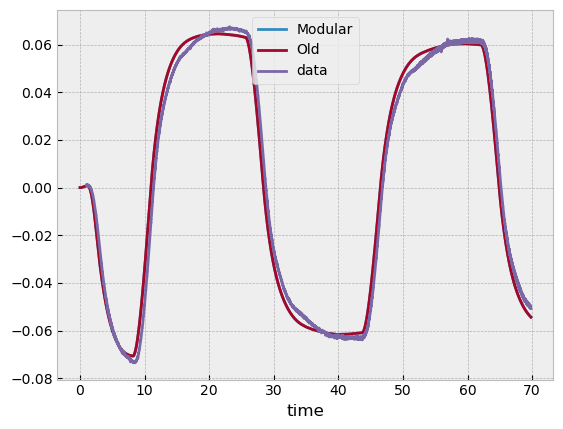

In [98]:
fig,ax=plt.subplots()
df.plot(y='r', label='Modular', ax=ax)
df_old.plot(y='r', label='Old', ax=ax)
data.rolling(window=100).mean().plot(y='r', label='data', ax=ax)

<Axes: >

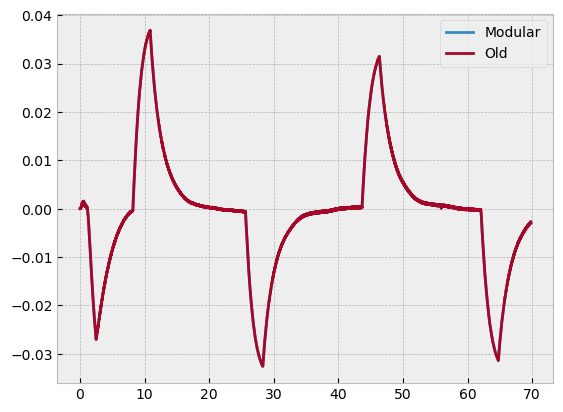

In [101]:
fig,ax=plt.subplots()
df.plot(y='r1d', label='Modular', ax=ax)
df_old.plot(y='r1d', label='Old', ax=ax)
#data.rolling(window=1000).mean().plot(y='r1d', label='data', ax=ax)

In [46]:
f_X_H = sp.Function('X_H')(u,v,r,delta)
f_Y_H = sp.Function('Y_H')(u,v,r,delta)
f_N_H = sp.Function('N_H')(u,v,r,delta)

f_X_R = sp.Function('X_R')(u,v,r,delta)
f_Y_R = sp.Function('Y_R')(u,v,r,delta)
f_N_R = sp.Function('N_R')(u,v,r,delta)

f_X_P = sp.Function('X_P')(u,v,r,delta)

In [47]:
X_eq = model.X_eq.subs(f_X_R,0)
Y_eq = model.Y_eq.subs(f_Y_R,0)
N_eq = model.N_eq.subs(f_N_R,0)

display(X_eq)
display(Y_eq)
display(N_eq)


Eq(m*(\dot{u} - r**2*x_G - r*v), X_{\dot{u}}*\dot{u} + X_H(u, v, r, delta))

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v} + Y_H(u, v, r, delta))

Eq(I_z*\dot{r} + m*x_G*(\dot{v} + r*u), N_{\dot{r}}*\dot{r} + N_{\dot{v}}*\dot{v} + N_H(u, v, r, delta))

In [48]:
model_same = model = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                                            ship_parameters=model_old.ship_parameters, 
                                            parameters=model_old.parameters, 
                                            control_keys=model_old.control_keys)
#model.subsystems['hull'] = hull

In [49]:
eq_X_H = sp.Eq(X_H,model_old.X_qs_eq.rhs)
eq_Y_H = sp.Eq(Y_H,model_old.Y_qs_eq.rhs)
eq_N_H = sp.Eq(N_H,model_old.N_qs_eq.rhs)
display(eq_X_H)
display(eq_Y_H)
display(eq_N_H)

Eq(X_H, X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{thrust}*thrust + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

Eq(Y_H, Y_{delta}*delta + Y_{r}*r + Y_{thrustdelta}*delta*thrust + Y_{thrust}*thrust + Y_{ur}*r*u + Y_{u}*u + Y_{vvdelta}*delta*v**2 + Y_{v}*v)

Eq(N_H, N_{delta}*delta + N_{r}*r + N_{thrustdelta}*delta*thrust + N_{thrust}*thrust + N_{ur}*r*u + N_{u}*u + N_{vvdelta}*delta*v**2 + N_{v}*v)

In [50]:
equations_hull = [eq_X_H, eq_Y_H, eq_N_H]
hull = PrimeEquationSubSystem(ship=model, equations=equations_hull)
model_same.subsystems['hull'] = hull

In [51]:
h_=np.mean(np.diff(data.index))
def lambda_jacobian2(x: np.ndarray, input: pd.Series) -> np.ndarray:
    
    states_dict = {
        'x0':x[0],
        'y0':x[1],
        'psi':x[2],
        'u' : x[3],
        'v' : x[4],
        'r' : x[5],
    }
    
    control = {key:value for key,value in zip(model.control_keys,input)}    
    return model_same.calculate_jacobian(states_dict=states_dict, control=control, h=h_)

In [52]:
hull.partial_derivative_lambdas

{'ddx_0X_H': <function _lambdifygenerated()>,
 'ddy_0X_H': <function _lambdifygenerated()>,
 'ddpsiX_H': <function _lambdifygenerated()>,
 'dduX_H': <function _lambdifygenerated(L, Xdeltadelta, Xu, Xuu, delta, rho, u, v)>,
 'ddvX_H': <function _lambdifygenerated(L, Xdeltadelta, Xu, Xvr, delta, r, rho, u, v)>,
 'ddrX_H': <function _lambdifygenerated(L, Xrr, Xvr, r, rho, v)>,
 'ddx_0Y_H': <function _lambdifygenerated()>,
 'ddy_0Y_H': <function _lambdifygenerated()>,
 'ddpsiY_H': <function _lambdifygenerated()>,
 'dduY_H': <function _lambdifygenerated(L, Ydelta, Yr, Ythrust, Ythrustdelta, Yu, Yur, Yv, Yvvdelta, delta, r, rho, thrust, u, v)>,
 'ddvY_H': <function _lambdifygenerated(L, Ydelta, Yr, Ythrust, Ythrustdelta, Yu, Yur, Yv, Yvvdelta, delta, r, rho, thrust, u, v)>,
 'ddrY_H': <function _lambdifygenerated(L, Yr, Yur, rho, u, v)>,
 'ddx_0N_H': <function _lambdifygenerated()>,
 'ddy_0N_H': <function _lambdifygenerated()>,
 'ddpsiN_H': <function _lambdifygenerated()>,
 'dduN_H': <functi

In [53]:
jac2 = lambda_jacobian2(x=[0,0,0,1,1,1], input=[0.1,100])
jac2

array([[ 1.        ,  0.        , -0.01      ,  0.01      , -0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.01      ,  0.        ,  0.01      ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.01      ],
       [ 0.        ,  0.        ,  0.        ,  0.99876307, -0.00542522,
        -0.02284597],
       [ 0.        ,  0.        ,  0.        , -0.02588754,  1.03842678,
         0.01957606],
       [ 0.        ,  0.        ,  0.        ,  0.02549931, -0.07551633,
         0.95232398]])

In [54]:
input = pd.Series(
{'delta':0.1,
 'thrust':100,
})
jac_old = ek.lambda_jacobian(x=[0,0,0,1,1,1], input=input)
jac_old

array([[ 1.        ,  0.        , -0.01      ,  0.01      , -0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.01      ,  0.        ,  0.01      ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.01      ],
       [ 0.        ,  0.        ,  0.        ,  0.99876307, -0.00542522,
        -0.02284597],
       [ 0.        ,  0.        ,  0.        , -0.02588754,  1.03842678,
         0.01957606],
       [ 0.        ,  0.        ,  0.        ,  0.02549931, -0.07551633,
         0.95232398]])

In [55]:
jac2/jac_old

array([[ 1., nan,  1.,  1., nan, nan],
       [nan,  1.,  1., nan,  1., nan],
       [nan, nan,  1., nan, nan,  1.],
       [nan, nan, nan,  1.,  1.,  1.],
       [nan, nan, nan,  1.,  1.,  1.],
       [nan, nan, nan,  1.,  1.,  1.]])

In [56]:
ek.lambda_f(x=np.array([0,0,0,1,1,1]), input=input)

array([ 1.        ,  1.        ,  1.        , -1.26993921,  1.60590011,
       -4.88484887])

In [57]:
lambda_f(x=np.array([0,0,0,1,1,1]), input=[0.1,100])

array([[ 1.        ],
       [ 1.        ],
       [ 1.        ],
       [-1.26993921],
       [ 1.60590011],
       [-4.88484887]])

In [58]:
eq = hull.equations['X_H']
eq

Eq(X_H, X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{thrust}*thrust + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

In [59]:
from vessel_manoeuvring_models.prime_system import standard_units
from vessel_manoeuvring_models import prime_system

u_prime, v_prime = sp.symbols("u' v'")
subs_prime = [
    (m, m / prime_system.df_prime.mass.denominator),
    (I_z, I_z / prime_system.df_prime.inertia_moment.denominator),
    (x_G, x_G / prime_system.df_prime.length.denominator),
    (u_prime, u / sp.sqrt(u**2 + v**2)),
    (v_prime, v / sp.sqrt(u**2 + v**2)),
    (r, r / (sp.sqrt(u**2 + v**2) / L)),
    (thrust, thrust / (sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
]


name='X_H'
unit = standard_units[name]
denominator = prime_system.df_prime.loc["denominator", unit]
eq_SI = sp.Eq(eq.lhs, eq.rhs.subs(subs_prime) * denominator)

In [60]:
unit

'force'

In [61]:
denominator

L**2*U**2*rho/2

In [62]:
subs_prime

[(m, 2*m/(L**3*rho)),
 (I_z, 2*I_z/(L**5*rho)),
 (x_G, x_G/L),
 (u', u/sqrt(u**2 + v**2)),
 (v', v/sqrt(u**2 + v**2)),
 (r, L*r/sqrt(u**2 + v**2)),
 (thrust, 2*thrust/(L**2*rho*(u**2 + v**2)))]

In [63]:
eq_SI

Eq(X_H, L**2*U**2*rho*(L**2*X_{rr}*r**2/(u**2 + v**2) + L*X_{vr}*r*v/sqrt(u**2 + v**2) + X_{deltadelta}*delta**2 + X_{uu}*u**2 + X_{u}*u + 2*X_{thrust}*thrust/(L**2*rho*(u**2 + v**2)))/2)

In [64]:
hull.get_eq_partial_derivatives(eq=eq_SI)['dduX_H']

L**2*U**2*rho*(-2*L**2*Xrr*r**2*u/(u**2 + v**2)**2 - L*Xvr*r*u*v/(u**2 + v**2)**(3/2) + Xu + 2*Xuu*u - 4*Xthrust*thrust*u/(L**2*rho*(u**2 + v**2)**2))/2

In [65]:
partial_derivative_prime = hull.get_eq_partial_derivatives(eq=eq)['dduX_H']
partial_derivative_prime

Xu + 2*Xuu*u

In [66]:
vmm = model
X_eq = vmm.X_eq.subs(f_X_H, hull.equations['X_H'].rhs)
Y_eq = vmm.Y_eq.subs(f_Y_H, hull.equations['Y_H'].rhs)
N_eq = vmm.N_eq.subs(f_N_H, hull.equations['N_H'].rhs)
A, b = sp.linear_eq_to_matrix([X_eq, Y_eq, N_eq], [u1d, v1d, r1d])

In [67]:
b

Matrix([
[                              X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{thrust}*thrust + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v - m*(-r**2*x_G - r*v)],
[    Y_{delta}*delta + Y_{r}*r + Y_{thrustdelta}*delta*thrust + Y_{thrust}*thrust + Y_{ur}*r*u + Y_{u}*u + Y_{vvdelta}*delta*v**2 + Y_{v}*v - m*r*u],
[N_{delta}*delta + N_{r}*r + N_{thrustdelta}*delta*thrust + N_{thrust}*thrust + N_{ur}*r*u + N_{u}*u + N_{vvdelta}*delta*v**2 + N_{v}*v - m*r*u*x_G]])

In [68]:
u_prime, v_prime = sp.symbols("u' v'")
h = sp.symbols("h")  # time step
subs_prime = [
    (m, m / prime_system.df_prime.mass.denominator),
    (I_z, I_z / prime_system.df_prime.inertia_moment.denominator),
    (x_G, x_G / prime_system.df_prime.length.denominator),
    (u_prime, u / sp.sqrt(u**2 + v**2)),
    (v_prime, v / sp.sqrt(u**2 + v**2)),
    (r, r / (sp.sqrt(u**2 + v**2) / L)),
    (thrust, thrust / (sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
]
subs = subs_prime
A_SI = A.subs([(u, u_prime), (v, v_prime)]).subs(subs)
b_SI = b.subs([(u, u_prime), (v, v_prime)]).subs(subs)
x_dot = sympy.matrices.dense.matrix_multiply_elementwise(
    A_SI.inv() * b_SI,  # (Slow...)
    sp.Matrix(
        [
            (u**2 + v**2) / L,
            (u**2 + v**2) / L,
            (u**2 + v**2) / (L**2),
        ]
    ),
)
x_ = sp.Matrix(
    [u * sp.cos(psi) - v * sp.sin(psi), u * sp.sin(psi) + v * sp.cos(psi), r]
)
f_ = sp.Matrix.vstack(x_, x_dot)
no_states = len(f_)
no_measurement_states = no_states - A.shape[0]
subs = {value: key for key, value in p.items()}
subs[psi] = sp.symbols("psi")
keys = list(set(subs.keys()) & set(f_.free_symbols))
subs_ = {key: subs[key] for key in keys}
expr = f_.subs(subs_)
_lambda_f = sp.lambdify(list(expr.free_symbols), expr, modules="numpy")
x, x1d = sp.symbols(r"\vec{x} \dot{\vec{x}}")  # State vector
eq_x = sp.Eq(x, sp.UnevaluatedExpr(sp.Matrix([x_0, y_0, psi, u, v, r])))
jac = sp.eye(6, 6) + f_.jacobian(eq_x.rhs.doit()) * h
keys = list(set(subs.keys()) & set(jac.free_symbols))
subs_ = {key: subs[key] for key in keys}
expr = jac.subs(subs_)
_lambda_jacobian = sp.lambdify(list(expr.free_symbols), expr, modules="numpy")

In [69]:
x_dot

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   L**2*rho*(u**2 + v**2)*(L**2*X_{rr}*r**2/(u**2 + v**2) + L*X_{vr}*r*v/(u**2 + v**2) + X_{deltadelta}*delta**2 + X_{uu}*u**2

In [70]:
jac_old = f_.jacobian(eq_x.rhs.doit())
sp.simplify(jac_old[3,3])

L**2*rho*(2*X_{deltadelta}*delta**2*u*sqrt(u**2 + v**2) + 2*X_{uu}*u*sqrt(u**2 + v**2) + 2*X_{u}*u**2 + X_{u}*v**2)/(sqrt(u**2 + v**2)*(-L**3*X_{\dot{u}}*rho + 2*m))

In [71]:
jac = model_same.jac
jac[3,3]

-2*Derivative(X_H(u, v, r, delta), u)/(L**3*X_{\dot{u}}*rho - 2*m)

In [72]:
hull.partial_derivatives['dduX_H']

L**2*Xdeltadelta*delta**2*rho*u + L**2*Xu*rho*u**2/(2*sqrt(u**2 + v**2)) + L**2*Xu*rho*sqrt(u**2 + v**2)/2 + L**2*Xuu*rho*u

In [73]:
sp.simplify(jac[3,3].subs(f_X_H.diff(u), hull.partial_derivatives['dduX_H']))

L**2*rho*(-Xu*u**2 + sqrt(u**2 + v**2)*(-2*Xdeltadelta*delta**2*u - Xu*sqrt(u**2 + v**2) - 2*Xuu*u))/(sqrt(u**2 + v**2)*(L**3*X_{\dot{u}}*rho - 2*m))

In [74]:
denominator = denominator.subs(U,sp.sqrt(u**2+v**2))

In [75]:
sp.simplify((hull.equations['X_H'].subs(subs_prime).rhs*denominator).diff(u))

L**3*X_{vr}*r*rho*u*v/(2*sqrt(u**2 + v**2)) + L**2*X_{deltadelta}*delta**2*rho*u + 2*L**2*X_{uu}*rho*u**3 + L**2*X_{uu}*rho*u*v**2 + 3*L**2*X_{u}*rho*u**2/2 + L**2*X_{u}*rho*v**2/2